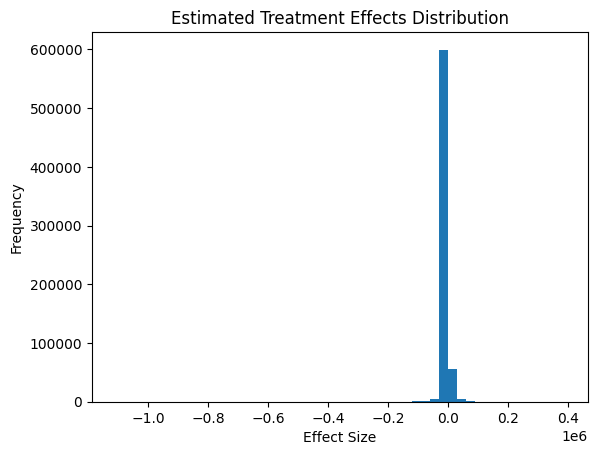

HSLcountall: 0.1581082775990756
teencountall: 0.2631988743226733
HSDcountall: 0.2303115108479104
gendercountall: 0.1793493415637571
Black_or_Hispanic: 0.16903199566658356


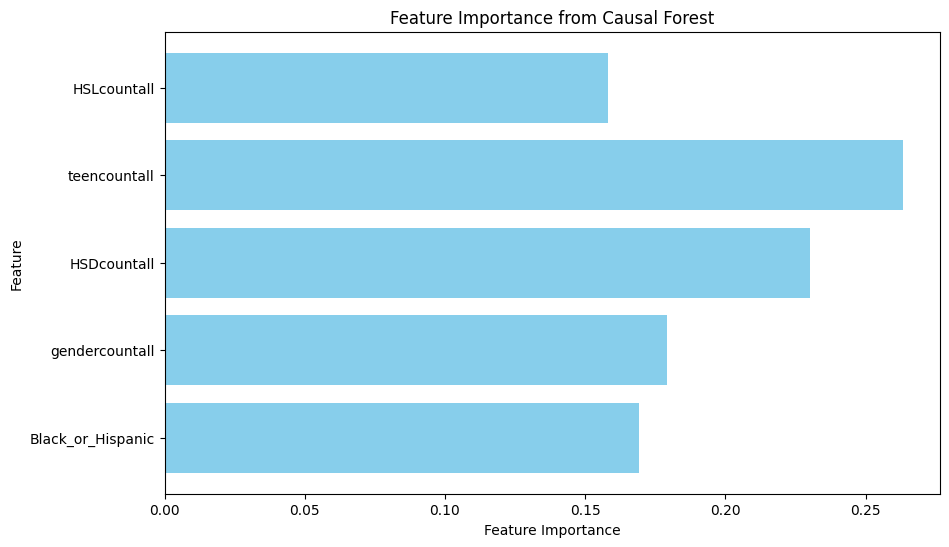

                            WLS Regression Results                            
Dep. Variable:                avewage   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.510
Date:                Sun, 21 Apr 2024   Prob (F-statistic):            0.00353
Time:                        03:53:04   Log-Likelihood:            -5.5541e+06
No. Observations:              668304   AIC:                         1.111e+07
Df Residuals:                  668302   BIC:                         1.111e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1668.2879      0.955  

divide by zero encountered in scalar divide


In [10]:
!pip install econml
import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm



# Load the datasets
state_panels_df = pd.read_csv(r"/content/combined_data_89-16.csv")
T_df = pd.read_csv(r"/content/processed_VZ_mw_data.csv")
T_df = T_df.rename(columns={'statefips': 'statenum'})

# Merge datasets
df_merged = pd.merge(state_panels_df, T_df, on=["statenum", "quarterdate"], how="inner")

# Define feature variables (X)
X = df_merged[['HSLcountall', 'teencountall', 'HSDcountall', 'gendercountall', 'Black_or_Hispanic']]

# Handling variable (T)
T = df_merged['T']  # Assuming 'T' is the treatment variable

# Outcome variable (Y)
Y = df_merged['avewage']

# Initialize the Causal Forest model
crf = CausalForestDML(model_y=GradientBoostingRegressor(),
                      model_t=GradientBoostingRegressor(),
                      criterion='mse', n_estimators=100,
                      min_samples_leaf=10,
                      max_depth=None)

# Fit the model
crf.fit(Y, T, X=X, W=None, inference='auto')

# Estimate causal effects
treatment_effects = crf.effect(X)

# Plot the distribution of estimated treatment effects
plt.hist(treatment_effects, bins=50)
plt.title('Estimated Treatment Effects Distribution')
plt.xlabel('Effect Size')
plt.ylabel('Frequency')
plt.show()

# Get confidence intervals
te_lower, te_upper = crf.effect_interval(X, alpha=0.05)

# Print feature importances
feature_names = ['HSLcountall', 'teencountall', 'HSDcountall', 'gendercountall', 'Black_or_Hispanic']
for feature_name, importance in zip(feature_names, crf.feature_importances_):
    print(f"{feature_name}: {importance}")

# Assuming feature_importances are the feature importance scores obtained from the model
feature_importances = crf.feature_importances_

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Causal Forest')
plt.gca().invert_yaxis()  # Invert the y-axis so the most important feature appears on top
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm

# Load your data here...
# state_panels_df = pd.read_csv('path_to_combined_data.csv')
# T_df = pd.read_csv('path_to_processed_data.csv')
# df_merged = pd.merge(state_panels_df, T_df, on=["statenum", "quarterdate"], how="inner")

# Assuming 'quarterdate' column exists in df_merged and is in the format 'YYYY-MM-DD'
df_merged['year'] = pd.to_datetime(df_merged['quarterdate']).dt.year

# Rest of your code to setup the variables X, T, Y
# ...

# Feature importances based on previous calculations
feature_importances = {
    'HSLcountall': 0.17338096892282462,
    'teencountall': 0.16552640478921346,
    'HSDcountall': 0.18297213069941945,
    'gendercountall': 0.2044431856854745,
    'Black_or_Hispanic': 0.273677309903068
}

# Calculate the total importance and create weights
total_importance = sum(feature_importances.values())
weights = {k: v / total_importance for k, v in feature_importances.items()}

# Add the weighted importance to the df_merged
df_merged['weights'] = df_merged.apply(
    lambda x: sum(x[feature] * weight for feature, weight in weights.items() if feature in x), axis=1)

# Define DiD required variables and perform the WLS regression with weights
# Here we assume the policy change occurred in 2010
policy_change_year = 2010
df_merged['post_policy'] = (df_merged['year'] >= policy_change_year).astype(int)
df_merged['treatment_x_post'] = df_merged['T'] * df_merged['post_policy']

# Define the outcome variable Y and the treatment variable T
Y = df_merged['avewage']  # replace 'avewage' with the actual column name for the outcome variable
T = df_merged['T']  # replace 'T' with the actual column name for the treatment variable

# Add constant term and define variables for the WLS model
X_did = df_merged[['treatment_x_post', 'T', 'post_policy']]
X_did = sm.add_constant(X_did)
weights_did = df_merged['weights']

# Perform Weighted Least Squares (WLS) regression
wls_model = sm.WLS(Y, X_did, weights=weights_did)
wls_results = wls_model.fit()

# Output regression results
print(wls_results.summary())

# Don't forget to replace 'path_to_combined_data.csv' and 'path_to_processed_data.csv'
# with the actual paths to your CSV files, and ensure 'avewage' and 'T' match your dataset.

